### Beispiel eines Neuronalen Netzes zur Vorhersage von Kundenabwanderung
Genutzt wird in diesem Fall ein **LSTM**-Netz (Long-Short-Term-Memory)
, welches besonders gut für die Analyse von längeren Sequenzen (Texte, Kursverläufe etc.) geeignet ist.
In unserem Fall sind dies Bestellverläufe verschiedener Kunden. Ziel ist es, das Netz auf einen Teil der Kundenbestellungen zu trainieren, und mit dem Rest zu testen ob das System diese richtig als abgesprungen oder nicht abgesprungen klassifiziert.

Im folgenden finden Sie die Codefragmente mit den zugehörigen Beschreibungen. Diese müssen nacheinander von Ihnen ausgeführt werden.

Import der notwendigen Bibliotheken:
* **Keras** - Hauptframework für Machine Learning. (Basiert auf Google's Tensorflow)
* **Numpy** - Unter anderem zur Durchführung von Vektorberechnungen.
* **Pandas** - Regelt den Import und die Formatierung von Daten. 

## Imports und Funktionen

In [152]:
import random as rn
from datetime import datetime

from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [153]:
RANDOM_SEED = 40

rn.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Funktion: *Inner-Join* auf zwei Datensätzen

In [154]:
def drop_missing_values_vise_versa(df1, df2, column_name):
    """Entferne die fehlenden Werte anhand einer Spalte
    
    Args:
        df1 (:obj:`pandas.DataFrame`): 1. DataFrame
        df2 (:obj:`pandas.DataFrame`): 2. DataFrame
        column_name (:obj:`str`): relevanter Spaltenname
    
    Returns:
        tuple of two :obj:`pandas.DataFrame`
    """
    
    assert column_name in df1.columns and column_name in df2.columns, 'Spaltenname muss in beiden DFs vorliegen.'

    drop_condition = df1[column_name].isin(df2[column_name]) == False
    df1 = df1.drop(df1[drop_condition].index)

    drop_condition = df2[column_name].isin(df1[column_name]) == False
    df2 = df2.drop(df2[drop_condition].index)

    return df1, df2

Funktion: welche fehlende Daten einer Zeitreihe auffüllt. Wenn kein Wert da ist tragen wir eine 0 ein.

In [155]:
def fill_dates(df, end_date):
    """Fülle die Zeitreihen bis zu einem gegebenen Datum auf
    
    Args:
        df (:obj:`pandas.DataFrame`): DataFrame mit Zeitreihen
        end_date (:obj:`datetime.datetime`)
    
    Returns:
        :obj:`pandas.DataFrame` aufgefüllter DataFrame
    """

    start_date = df['date'].iloc[0]
    if start_date > end_date or len(df) == 0:
        return df

    months_diff = ((end_date.year - start_date.year) * 12 + end_date.month - start_date.month)
    date_list = [start_date + relativedelta(months=x) for x in range(0, months_diff)]
    date_frame = pd.DataFrame(date_list)
    date_frame.columns = ['date']
    value = pd.merge(date_frame, df, how='left').fillna(0)
    value = value.drop(['date'], axis=1)

    return value

## Einlesen der Daten mithilfe von **Pandas**
* Es wird zwischen X und Y-Werten unterschieden.
* Die X-Werte sind in unserem Fall die Bestellverläufe.
* Der Y-Wert ist ein *boolean*-Wert, welcher besagt ob ein Kunde abgesprungen ist.

In [156]:
x_data = pd.read_csv("cleaned_orders.csv", header=0, index_col=0, sep=",", decimal=".", dtype={0:int})
x_data['date'] = pd.to_datetime(x_data.date, format='%Y-%m-%d')

x_data['date'].describe() # scope: monthly, 2015-02 until 2019-09

count                   20112
unique                     57
top       2019-02-01 00:00:00
freq                      458
first     2015-02-01 00:00:00
last      2019-10-01 00:00:00
Name: date, dtype: object

In [157]:
x_data = pd.read_csv("cleaned_orders.csv", header=0, index_col=0, sep=",", decimal=".", dtype={0:int})
x_data['date'] = pd.to_datetime(x_data.date, format='%Y-%m-%d') # scope: monthly, 2015-02 until 2019-09
x_data = x_data.drop("quantity", axis=1)
x_data = x_data[x_data.date < '2018-09-01'] # spätere Daten wurden zur Churn Bestimmung (y-Daten) benutzt


In [158]:
y_data = pd.read_csv("cleaned_y_data_friends.csv", header=0, index_col=0, sep=",", dtype={0:int,1:int})
y_data = y_data.sort_values('recipient').reset_index(drop=True)

In [159]:
x_data, y_data = drop_missing_values_vise_versa(x_data, y_data, 'recipient')

## Data-Exploration

Wieviele Kunden haben wir im Dataset?

In [160]:
x_data.nunique() # Anzahl der "unique" Werte pro Spalte (es gibt viele Spalten pro Rezipient)

recipient     352
date           43
sales        1357
dtype: int64

Wie ist der Umsatz auf die Kunden verteilt?

Text(0, 0.5, 'Summe Umsatz in Mio')

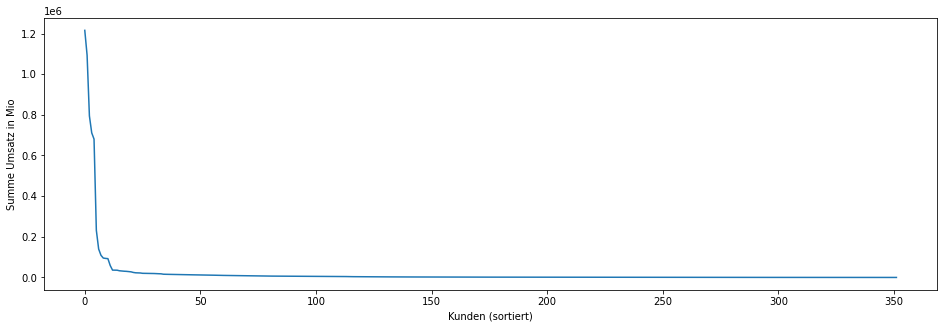

In [161]:
grouped = x_data.groupby('recipient', as_index=False)
recipients_total_sales = grouped.agg(np.sum)
recipients_total_sales.sort_values(by="sales", ascending=False, inplace=True)
recipients_total_sales.reset_index(inplace=True, drop=True)
plt.plot(recipients_total_sales["sales"])
plt.xlabel("Kunden (sortiert)")
plt.ylabel("Summe Umsatz in Mio")

Es sieht so aus als währen viele "leere" Kunden dabei. 
Schauen wir uns das genauer an. Eine log-Skala ist angebracht.

Text(0, 0.5, 'log Summe Umsatz')

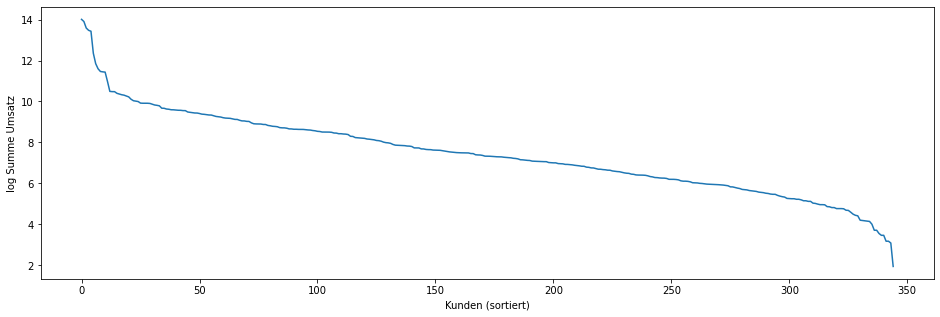

In [162]:
# recipients_total_sales[recipients_total_sales.sales == 0].count()
plt.plot(np.log(recipients_total_sales["sales"]))
plt.xlabel("Kunden (sortiert)")
plt.ylabel("log Summe Umsatz")

## Freunschaftsbeziehungen

Die sozialen Beziehungen zwischen den Kunden simulieren wir hier stark simplifiziert.
Wir erfinden einfach einen Wert, der die Anzahl von "Churner-Freunden" angibt, und der ist höher bei Churnern.

In [163]:
# y_data["churner_friends"] = [rn.randint(4,10) if row[2]==1 else rn.randint(0,6) \
#                                          for row in y_data.itertuples()]
friends = y_data.iloc[:,[0,2]]
y_data = y_data.iloc[:,[0,1]]

In [164]:
friends.head(5)

,recipient,churner_friends
0,11675,1
1,12589,4
2,13593,4
3,14080,4
4,14089,0


Veranschaulichung der Abhängigkeit zwischen "ist churned" und "Anzahl der churned friends"

In [165]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    merged = y_data.merge(friends)
    merged = merged.sort_values(by=['churner_friends'])

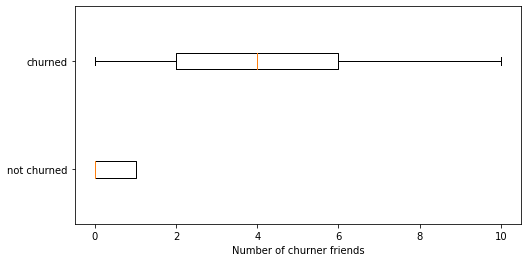

In [166]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
labels=["not churned", "churned"]
ax.boxplot([merged.iloc[:,1],merged.iloc[:,2]], labels=labels, vert=False)
ax.set_xlabel("Number of churner friends")
plt.show()


Die Freunschaftsbeziehungen müssen normalisiert werden, bevor sie vom NN verarbeitet werden können!

In [167]:
friends=(friends['churner_friends']-friends['churner_friends'].mean())/friends['churner_friends'].std()

In [168]:
friends.head(5)

0   -1.219607
1   -0.097739
2   -0.097739
3   -0.097739
4   -1.593563
Name: churner_friends, dtype: float64

## Transformation der gegebenen Daten

Wir wollen dem Algorithmus eine Zeitreihe der Sales eines jeden Kunden übergeben. Dazu ist noch etwas Data-wrangling nötig.

Die drei folgenden Code-Zellen dienen der Transformation der X-Werte in ein 3D-Array, um diese für das Netzwerk lesbar zu machen.

In [169]:
x_data_dict =  dict()
x_data_grouped = x_data.groupby('recipient')
for recipient in x_data_grouped.groups:
    x_data_dict[recipient] = pd.DataFrame(x_data_grouped['date','sales'].get_group(recipient))
assert len(x_data_dict) == len(y_data) # hier testen wir ob wir gleichviele Daten für x und y haben

In [170]:
X = list()
for key, item in x_data_dict.items():
    X.append(fill_dates(item, datetime.strptime("2018-09-01","%Y-%m-%d")).values.tolist())

In [171]:
X = pad_sequences(X, value=-1,dtype='float32')
y = np.array(y_data['churned'].values)
y = y.reshape(y.shape[0],1)
friends = friends.values.reshape(friends.shape[0],1)

Nun haben wir die gewünschten Zeitreihen. Um einen besseren Eindruck zu bekommen plotten wir den Verlauf von fünf Kunden.
Versuche hier mehr Kunden anzeigen zu lassen (insgesamt sind es 252). Was musst du verändern?

Text(0, 0.5, 'Umsatz')

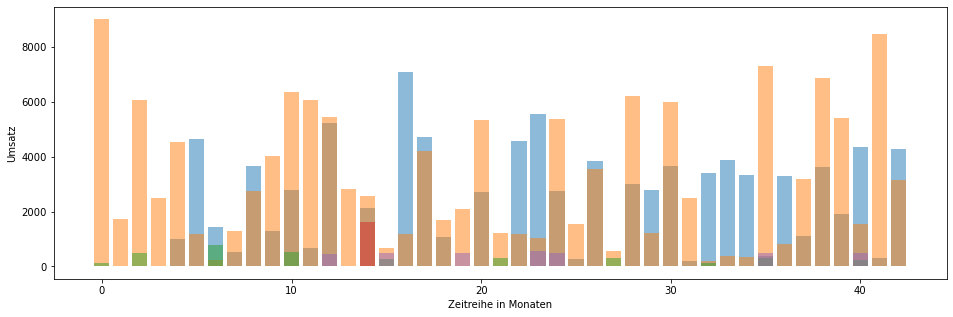

In [172]:
# Die X-Achse stellt die Zeit dar:
timesteps = np.arange(len(X[0]))

# Um die Zeitreihe eines einzelnen Kunden zu bekommen (wird im Loop angewendet)
# x1 = X[0].flatten() 

fig, ax = plt.subplots() # fig ist die ganze Grafik, ax ist die Oberfläche auf dem wir das Diagramm zeichnen können

# Nun plotten wir für jeden Kunden "i" die Umsätze
for i in range(5):
    ax.bar(timesteps, X[i].flatten(), alpha=.5)
ax.set_xlabel("Zeitreihe in Monaten")
ax.set_ylabel("Umsatz")

In [173]:
# fig, axs = plt.subplots(2)
# fig.subplots_adjust(hspace=0.5)
# top_y_lim = 7900
# axs[0].bar(timesteps, X[8].flatten(), alpha=1)
# axs[0].set_ylim(top=top_y_lim)
# axs[0].set_ylabel("Umsatz")
# axs[0].set_title("Ein Kunde")
# axs[1].bar(timesteps, X[0].flatten(), alpha=1)
# axs[1].set_ylim(top=top_y_lim)
# axs[1].set_xlabel("Zeitreihe in Monaten")
# axs[1].set_ylabel("Umsatz")
# axs[1].set_title("Anderer Kunde")
# plt.savefig("churned_friends.png", dpi=500)

## Trennung in Training- und Test-Daten

70% Trainings- und 30% Testdaten.
Freunschaftsbeziehungen und der zeitliche Verlauf werden als Input voneinander getrennt.

In [174]:
X_time_train, X_time_test, X_friends_train, X_friends_test, y_train, y_test = train_test_split(
    X, friends, y, train_size=0.7, random_state=RANDOM_SEED
)

In [175]:
print(f'X_time_train: {X_time_train.shape}')
print(f'X_time_test: {X_time_test.shape}')
print(f'X_friends_train: {X_friends_train.shape}')
print(f'X_friends_test: {X_friends_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_time_train: (246, 43, 1)
X_time_test: (106, 43, 1)
X_friends_train: (246, 1)
X_friends_test: (106, 1)
y_train: (246, 1)
y_test: (106, 1)


## Das DL-Modell

**An dieser Stelle sind Sie gefragt..**
Das nachfolgende Codefragment enthält 4 modifizierbare Parameter, welche essenziell für die Genauigkeit des Netzwerks sind.
Diese sind so initialiert, dass das Netwerk ohne Veränderung eine schlechte Performance aufweist.
Ihre Aufgabe ist es nun diese Parameter so anzupassen, dass eine möglichst hohe Genauigkeit erzielt wird.

Die Parameter sind wie folgt beschrieben:
* **learning_rate**: Lernrate des Minimierungs-Algorithmus der Kostenfunktion (default: 0.00001, range: 0-∞)
* **lstm_cells**: Anzahl der Memory-Cells des Netzwerks. Besitzt ein Netzwerk mehr Zellen, kann es sich eine größere Anzahl an Merkmalen merken. Zu viele können zu *Overfitting* führen. (default: 1, range: 1-∞)
* **dropout**: Anteil der Merkmale, die zufällig gelöscht werden. Wirkt *Ovefitting* entgegen (default: 0.5, range: 0-1)
* **epochs**: Anzahl der Traingsdurchläufe (default: 10, range: 1-∞)

In [176]:
learning_rate = 0.01
lstm_cells = 5
dropout = 0.2
epochs = 25

In [177]:
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(X_time_train.shape[1],1)))
model.add(LSTM(lstm_cells, recurrent_dropout=dropout))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['acc']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 43, 1)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


Die nachfolgende Code-Zelle enthält den Aufruf der *fit*-Methode, welche das Training des Netzes mit den oben angegebenen Parametern startet. Anschließend wird eine Zusammenfassung des Traingsverlaufs ausgegeben.

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/8 [=========================>....] - ETA: 0s - loss: 0.6921 - acc: 0.5714WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_fu

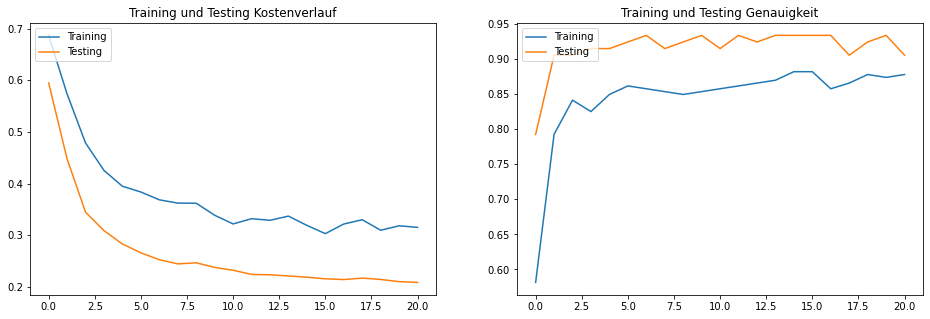

In [178]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, restore_best_weights=True, patience=5)
history = model.fit(x=X_time_train,y=y_train,epochs=epochs, verbose=1, callbacks=[es], validation_data=(X_time_test, y_test))
scores = model.evaluate(X_time_test, y_test, verbose=0)

plt.rcParams["figure.figsize"] = (16, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Testing')
ax1.legend(loc="upper left")
ax1.set_title("Training und Testing Kostenverlauf")
ax2.plot(history.history['acc'], label='Training')
ax2.plot(history.history['val_acc'], label='Testing')
ax2.legend(loc="upper left")#
ax2.set_title("Training und Testing Genauigkeit")
plt.show()

print("Genauigkeit: %.2f%%" % (scores[1]*100))
print(str(round(X_time_test.shape[0] * scores[1])) + " von " + str(X_time_test.shape[0]) + " Beispielen richtig klassifiziert!")

In [179]:
input_time = Input(shape=(X_time_train.shape[1],1))
input_friends = Input(shape=(X_friends_train.shape[1]))

## Combined Model
x = Masking(mask_value=-1)(input_time)
x = LSTM(lstm_cells, recurrent_dropout=dropout)(x)
x = Dropout(dropout)(x)
x = concatenate([x, input_friends])

outputs = Dense(1, activation='sigmoid')(x)

model = Model(
    inputs=[input_time, input_friends],
    outputs=outputs,
    name="lstm_friendship_model",
)

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['acc'],
)


Model: "lstm_friendship_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 43, 1)]      0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 43, 1)        0           input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 5)            140         masking_3[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 5)            0           lstm_3[0][0]                     
______________________________________________________________________________

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/8 [=========================>....] - ETA: 0s - loss: 0.4862 - acc: 0.7723WA

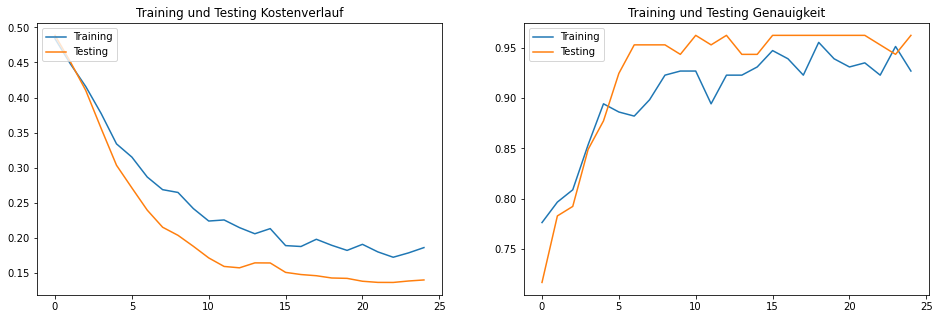

In [180]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, restore_best_weights=True, patience=5)
history = model.fit(x=[X_time_train, X_friends_train],y=y_train,epochs=epochs, verbose=1, callbacks=[es], validation_data=([X_time_test, X_friends_test], y_test))
scores = model.evaluate([X_time_test, X_friends_test], y_test, verbose=0)

plt.rcParams["figure.figsize"] = (16, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Testing')
ax1.legend(loc="upper left")
ax1.set_title("Training und Testing Kostenverlauf")
ax2.plot(history.history['acc'], label='Training')
ax2.plot(history.history['val_acc'], label='Testing')
ax2.legend(loc="upper left")#
ax2.set_title("Training und Testing Genauigkeit")
plt.show()

print("Genauigkeit: %.2f%%" % (scores[1]*100))
print(str(round(X_time_test.shape[0] * scores[1])) + " von " + str(X_time_test.shape[0]) + " Beispielen richtig klassifiziert!")